In [57]:
import numpy as np
import scipy.stats as si
import pandas as pd
import math
import matplotlib.pyplot as plt

In [ ]:
T = 1
s = 5
L = 100
K = 70
a = 0.08
b = 0.05
sigma = 0.02
P0T = np.exp(-b * T)
P0s = np.exp(-b * s)
sigmaP = (sigma / a) * (1 - np.exp(-a * (s - T))) * np.sqrt((1 - np.exp(-2 * a * T)) / (2 * a))
h = (np.log((L * P0s) / (P0T * K))) / sigmaP + sigmaP / 2
C = L * P0s * si.norm.cdf(h, 0.0, 1.0) - K * P0T * si.norm.cdf(h - sigmaP, 0.0, 1.0)

In [3]:
C

11.307679858959219

In [4]:
0.055265 - (0.003637)**2 / (0.051635 - 0.055265)

0.05890901349862259

In [5]:
0.048006 - (0.003637)**2 / (0.051635 - 0.048006)

0.044360982364287684

In [39]:
# solve two equations
def solver(alpha, exp, dw):
    # dw is σ√dt
    r = exp - (dw)**2 / (alpha - exp) 
    return r

In [40]:
#  build tree and calculate the interest rates for a 30 periods
def VTree(period, sigma, r0, theta, k, dt):
    dx = k * (theta - r0) * dt
    dw = sigma * np.sqrt(dt)
    nodes = [0.0] * ((2 * period + 1) * (period + 1)) 
    nodes = np.reshape(nodes, (2 * period + 1, period + 1))
    nodes[period, 0] = r0
    
    # expected rate for current time
    for i in range(1, period + 1, 1):
        nodes[period, i] = nodes[period, i - 1] + k * (theta - nodes[period, i - 1]) * dt
    
    # use the expected rate to calculate the up and down rates
    for i in range(1, period + 1, 2):
        nodes[period - 1, i] = nodes[period, i - 1] + k * (theta - nodes[period, i - 1]) * dt + dw
        nodes[period + 1, i] = nodes[period, i - 1] + k * (theta - nodes[period, i - 1]) * dt - dw
        nodes[period, i] = 0
    
    # extend the recombinding tree with a solver
    for i in range(2, period + 1, 1):
        # in even period
        if i%2 == 0:
            for j in range(period - 2, period - 2 - i, -2):
                alpha = nodes[j + 2, i]
                exp = nodes[j + 1, i - 1] + k * (theta - nodes[j + 1, i - 1]) * dt
                nodes[j, i] = solver(alpha, exp, dw)
                
            for j in range(period + 2, period + 2 + i, 2):
                alpha = nodes[j - 2, i]
                exp = nodes[j - 1, i - 1] + k * (theta - nodes[j - 1, i - 1]) * dt
                nodes[j, i] = solver(alpha, exp, dw)      
        
        # in odd period
        else:
            for j in range(period - 3, period - 2 - i, -2):
                alpha = nodes[j + 2, i]
                exp = nodes[j + 1, i - 1] + k * (theta - nodes[j + 1, i - 1]) * dt
                nodes[j, i] = solver(alpha, exp, dw)
            
            for j in range(period + 3, period + 2 + i, 2):
                alpha = nodes[j - 2, i]
                exp = nodes[j - 1, i - 1] + k * (theta - nodes[j - 1, i - 1]) * dt
                nodes[j, i] = solver(alpha, exp, dw)                    
    
    return nodes

In [47]:
Tree = pd.DataFrame(VTree(30, 0.0126, 0.05121, 0.15339, 0.025, 1 / 12))

In [49]:
Tree.to_csv('‪Tree.csv')

In [151]:
period = 30
sigma = 0.0126
r0 = 0.05121
theta = 0.15339
k = 0.025
dt = 1 /12

# risk-neutral results
rndist = [0.0] * (3 * (period + 1))
rndist = np.reshape(rndist, (3, period + 1))
rndist[0, 0] = r0
rndist[1, 0] = r0
rndist[2, 0] = r0

# Monte Carlo results
mc = [0.0] * (3 * (period + 1))
mc = np.reshape(mc, (3, period + 1))
mc[0, 0] = r0
mc[1, 0] = r0
mc[2, 0] = r0
for i in range(1, period + 1, 1):
    # calculate according to risk-neutral equation
    rndist[1, i] = rndist[1, i - 1] + k * (theta - rndist[1, i - 1]) * dt
    rndist[0, i] = rndist[1, i] + sigma * np.sqrt(i * dt)
    rndist[2, i] = rndist[1, i] - sigma * np.sqrt(i * dt)
    
    # calculate according to Monte Carlo, simulate 10000 times
    mc[1, i] = mc[1, i - 1] + k * (theta - mc[1, i - 1]) * dt + sigma * np.mean(np.random.normal(0, 1, 10000))
    mc[0, i] = mc[1, i] + sigma * np.sqrt(i * dt)
    mc[2, i] = mc[1, i] - sigma * np.sqrt(i * dt)
rndist = np.transpose(rndist)
mc = np.transpose(mc)

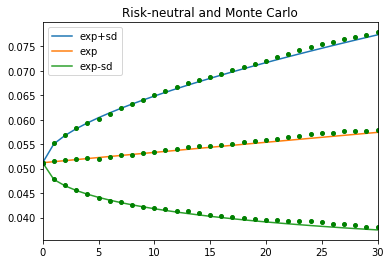

In [154]:
rndist = pd.DataFrame(rndist)
mc = pd.DataFrame(mc)
rndist.columns = ['exp+sd', 'exp', 'exp-sd']
mc.columns = ['exp+sd_mc', 'exp_mc', 'exp-sd_mc']
rndist.plot()
plt.plot(mc,'go', markersize=4)
plt.title('Risk-neutral and Monte Carlo')
plt.show()